# HiResIreland

In [1]:
import glob
import itertools
import os
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from climag import climag
from climag import climag_plot as cplt
import seaborn as sns

In [2]:
DATA_DIR_BASE = os.path.join("/run/media/nms/MyPassport/HiResIreland")

In [3]:
# directory to store outputs
DATA_DIR = os.path.join(DATA_DIR_BASE, "IE")
os.makedirs(DATA_DIR, exist_ok=True)

In [4]:
# Moorepark met station coords
LON, LAT = -8.26389, 52.16389

In [5]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries_all.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")
ie_bbox = gpd.read_file(
    GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE_BBOX_DIFF"
)
ie_ne = gpd.read_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX_DIFF")

## Read a subset (historical)

In [6]:
exp, model = "historical", "EC-EARTH"

In [25]:
data = xr.open_mfdataset(
    list(
        itertools.chain(
            *list(
                glob.glob(
                    os.path.join(DATA_DIR_BASE, "COSMO5-CLM", exp, model, e)
                )
                for e in [
                    f"*mean_T_2M*{model}*{exp}*.nc",
                    f"S1_daymean*{model}*{exp}*.nc",
                    f"*ET*{model}*{exp}*.nc",
                    f"*TOT_PREC*{model}*{exp}*.nc",
                    f"*ASOB_S*{model}*{exp}*.nc",
                ]
            )
        )
    ),
    chunks="auto",
    decode_coords="all",
)

In [26]:
# rename and assign attributes to ET var
data = data.rename({"w": "PET"})
data["PET"].attrs["long_name"] = "evapotranspiration"
data["PET"].attrs["units"] = "mm"

In [27]:
data

<xarray.Dataset>
Dimensions:       (time: 11323, rlon: 186, rlat: 200, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 2005-12-31T10...
  * rlon          (rlon) float64 -3.36 -3.325 -3.29 -3.255 ... 3.045 3.08 3.115
  * rlat          (rlat) float64 -3.38 -3.345 -3.31 -3.275 ... 3.515 3.55 3.585
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(200, 186), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(200, 186), meta=np.ndarray>
    rotated_pole  int32 1
    height_2m     float32 2.0
Dimensions without coordinates: bnds
Data variables:
    ASWDIR_S      (time, rlat, rlon) float32 dask.array<chunksize=(4875, 86, 80), meta=np.ndarray>
    ASWDIFD_S     (time, rlat, rlon) float32 dask.array<chunksize=(4875, 86, 80), meta=np.ndarray>
    ASWDIFU_S     (time, rlat, rlon) float32 dask.array<chunksize=(4875, 86, 80), meta=np.ndarray>
    ALB_RAD       (time, rlat, rlon) float32 dask.array<chunksize=(4875, 86, 80), meta=np.ndarray>
    ASOB_S        (time, rlat, rlon) float32 dask.array<chunksize=(365, 111, 101), meta=np.ndarray>
    TOT_PREC      (time, rlat, rlon) float32 dask.array<chunksize=(365, 111, 101), meta=np.ndarray>
    T_2M          (time, rlat, rlon) float32 dask.array<chunksize=(365, 111, 101), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(6679, 111, 101), meta=np.ndarray>
Attributes:
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    history:         Wed Mar 01 06:14:44 2023: cdo -s -L -f nc4c -z zip_9 -da...
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    contact:         Paul Nolan
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

In [28]:
# copy time_bnds
data_time_bnds = data.coords["time_bnds"]

In [29]:
# copy CRS
data_crs = data.rio.crs

In [30]:
data_crs

CRS.from_wkt('GEOGCRS["undefined",BASEGEOGCRS["undefined",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["Pole rotation (netCDF CF convention)",METHOD["Pole rotation (netCDF CF convention)"],PARAMETER["Grid north pole latitude (netCDF CF convention)",36.5999984741211,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["Grid north pole longitude (netCDF CF convention)",172.100006103516,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["North pole grid longitude (netCDF CF convention)",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

In [31]:
# convert Moorepark met station coordinates to rotated pole
cds = climag.rotated_pole_point(data=data, lon=LON, lat=LAT)

## Clip to Ireland's boundary

In [32]:
data = data.rio.clip(ie.buffer(1).to_crs(data_crs), all_touched=True)

In [15]:
# number of grid cells with data
len(
    data.groupby("time.season")
    .mean(dim="time")["T_2M"][0]
    .values.flatten()[
        np.isfinite(
            data.groupby("time.season")
            .mean(dim="time")["T_2M"][0]
            .values.flatten()
        )
    ]
)

6118

## Visualise spin-up year

In [33]:
data_ie = data.sel(time="1975")

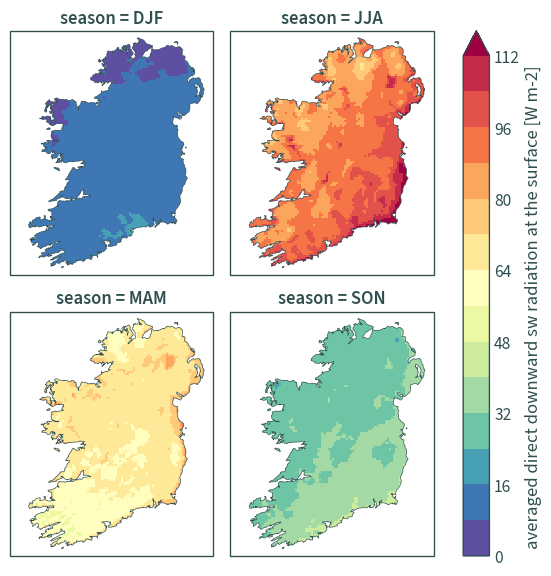

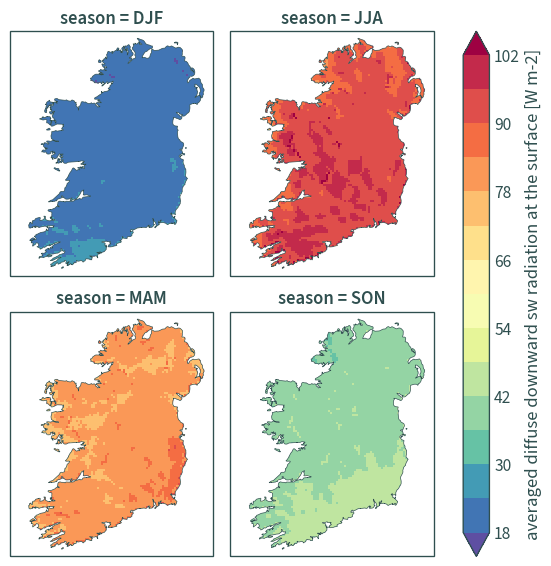

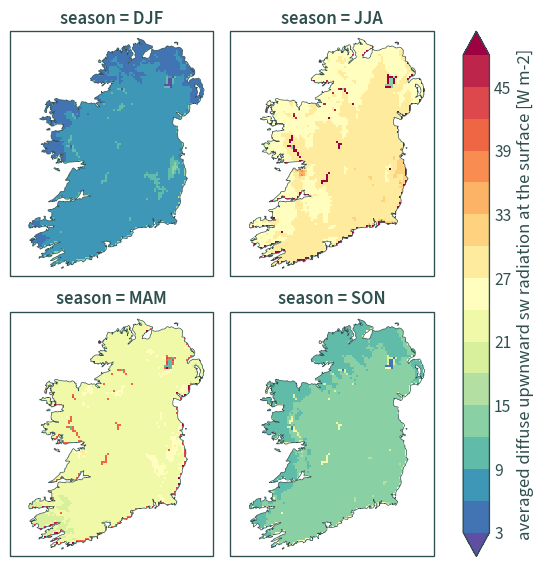

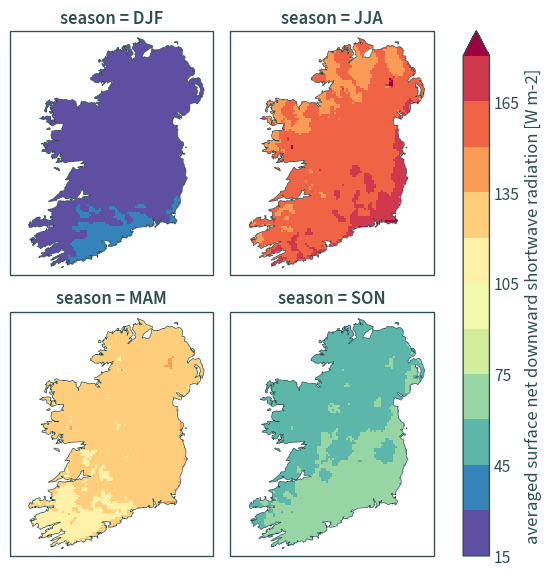

In [34]:
for var in ["ASWDIR_S", "ASWDIFD_S", "ASWDIFU_S", "ASOB_S"]:
    cplt.plot_averages(
        data=data_ie,
        var=var,
        averages="season",
        boundary_data=ie_ne,
        cbar_levels=15,
    )

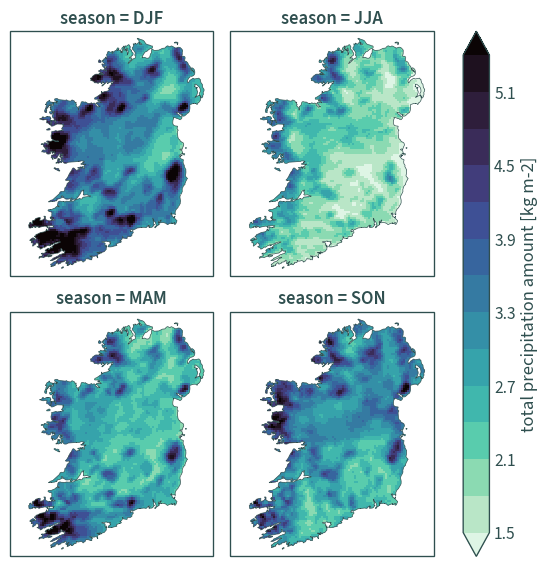

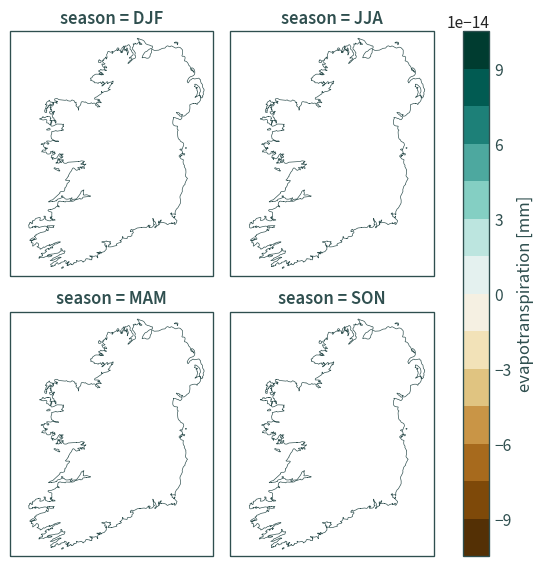

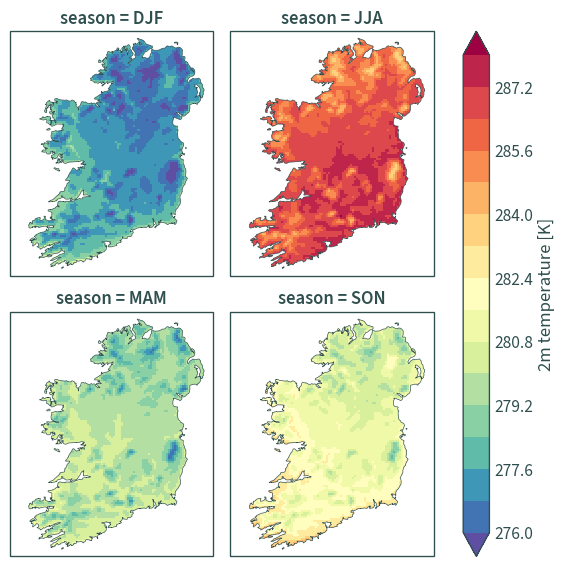

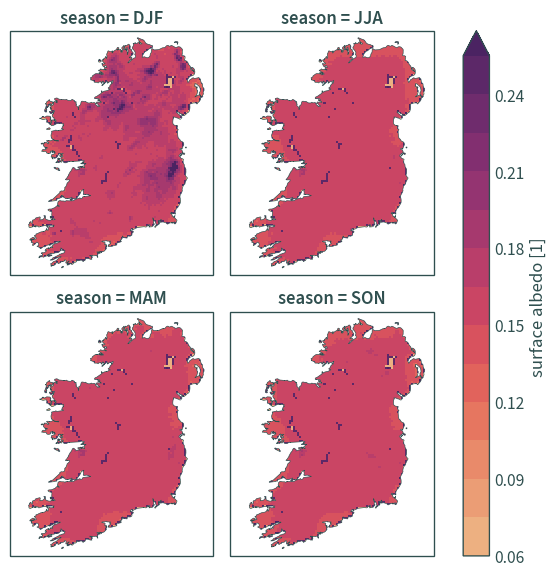

In [19]:
for var in ["TOT_PREC", "PET", "T_2M", "ALB_RAD"]:
    cplt.plot_averages(
        data=data_ie,
        var=var,
        averages="season",
        boundary_data=ie_ne,
        cbar_levels=15,
    )

### Time series

In [35]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1975", "1977")
)

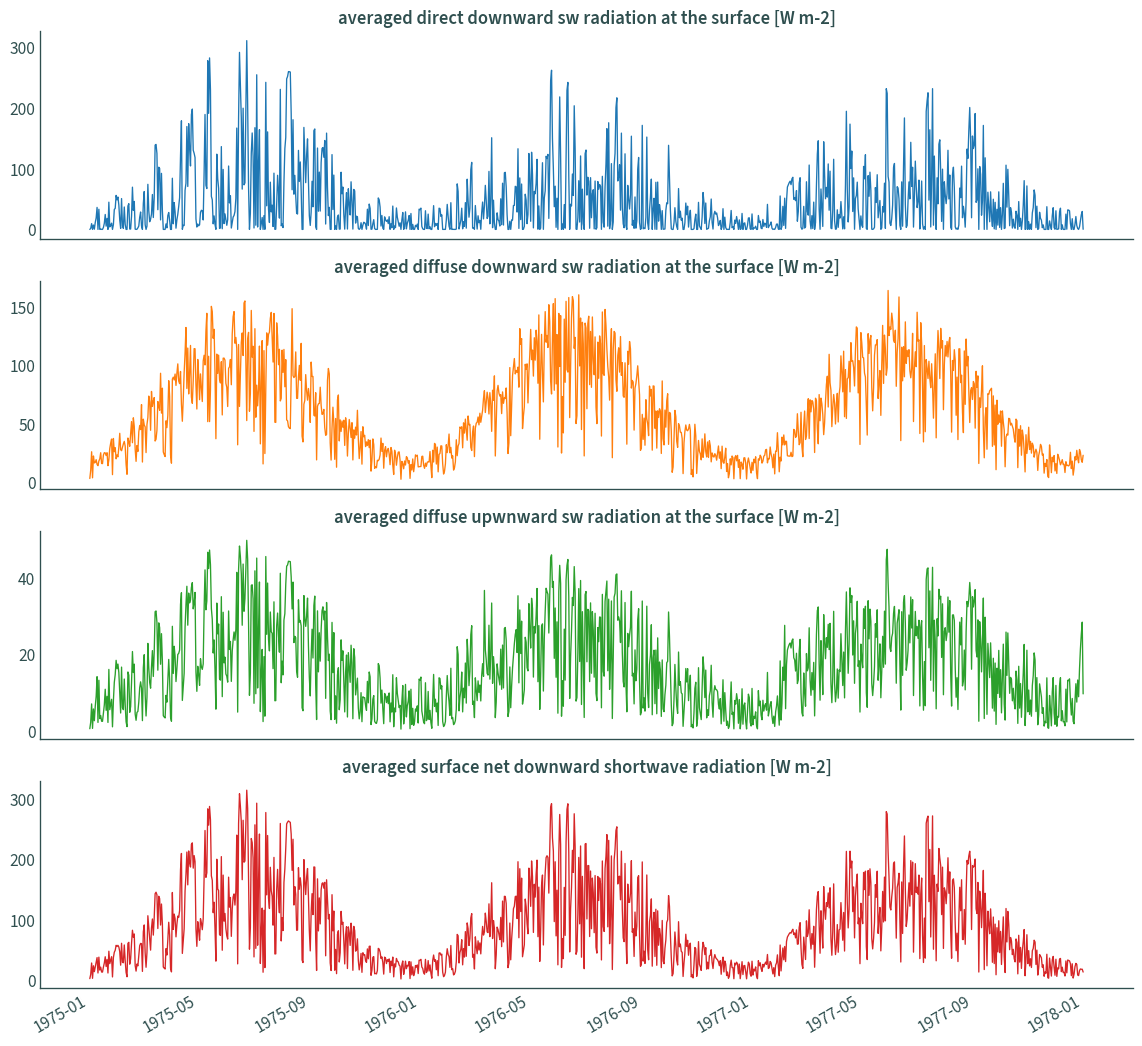

In [36]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in ["ASWDIR_S", "ASWDIFD_S", "ASWDIFU_S", "ASOB_S"]:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(4, 1),
    figsize=(12, 11),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=1,
)
sns.despine()
plt.tight_layout()
plt.show()

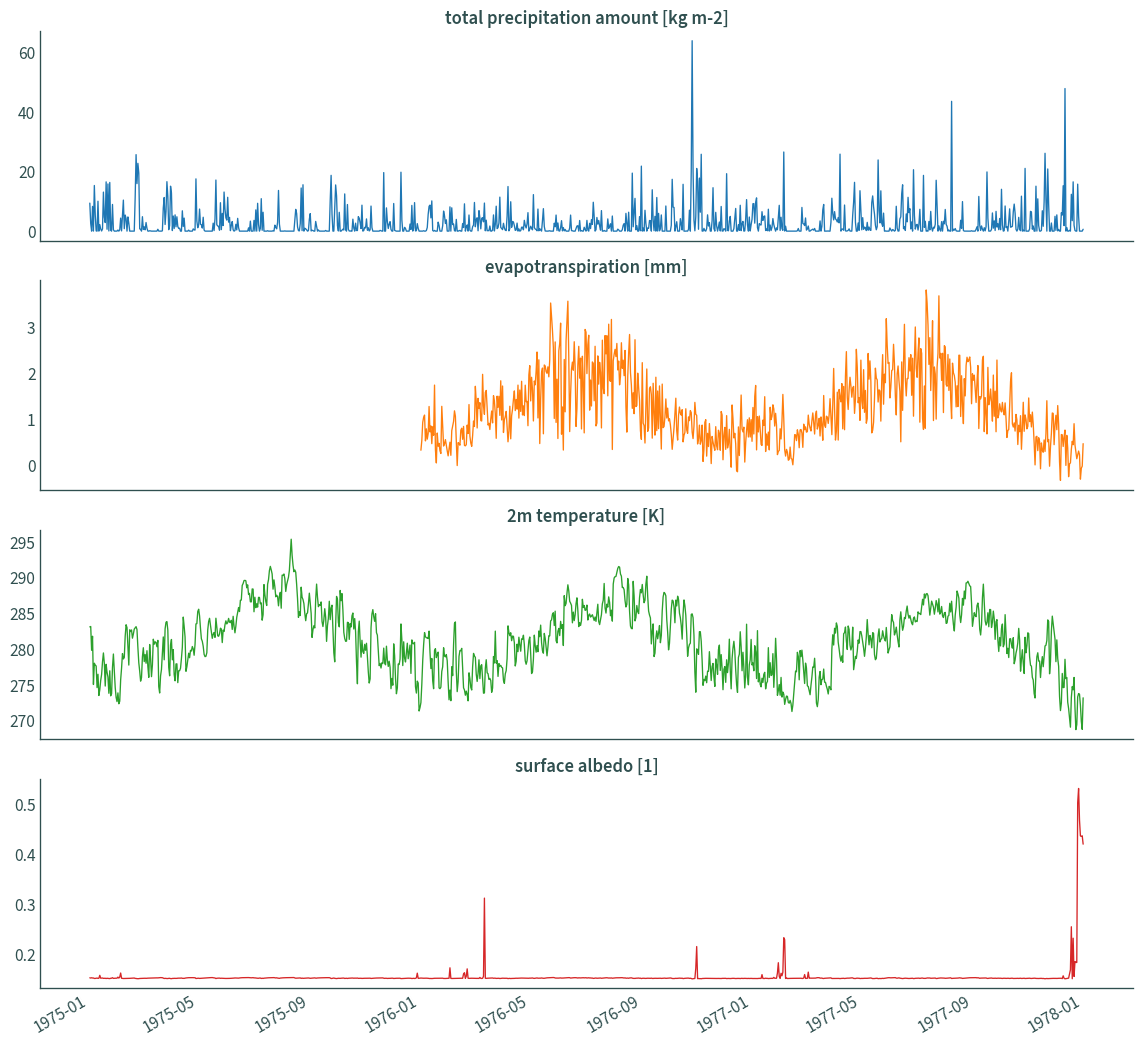

In [23]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in ["TOT_PREC", "PET", "T_2M", "ALB_RAD"]:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(4, 1),
    figsize=(12, 11),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=1,
)
sns.despine()
plt.tight_layout()
plt.show()

## Visualise fields

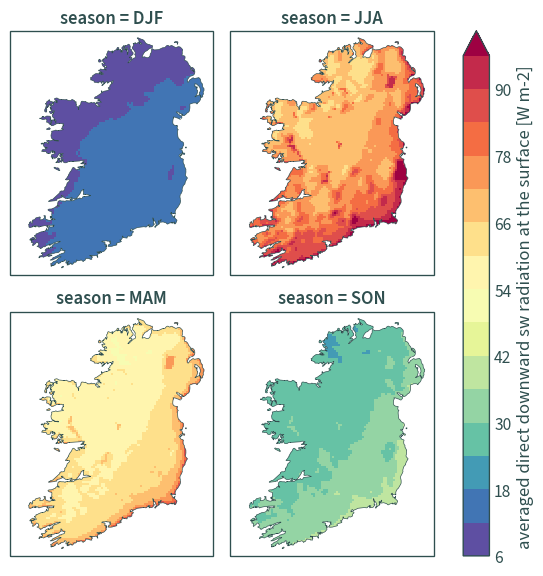

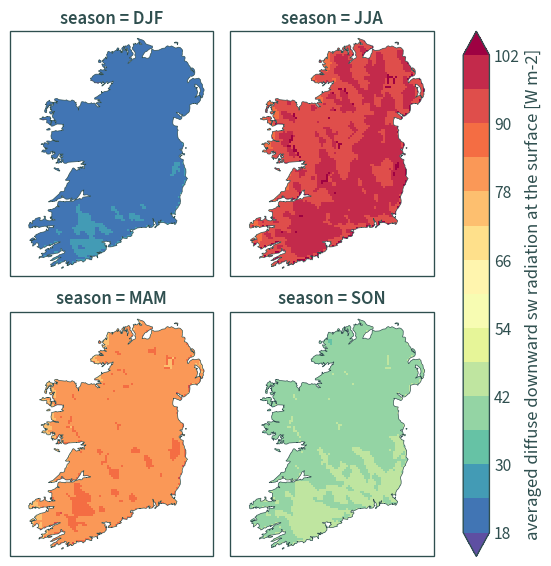

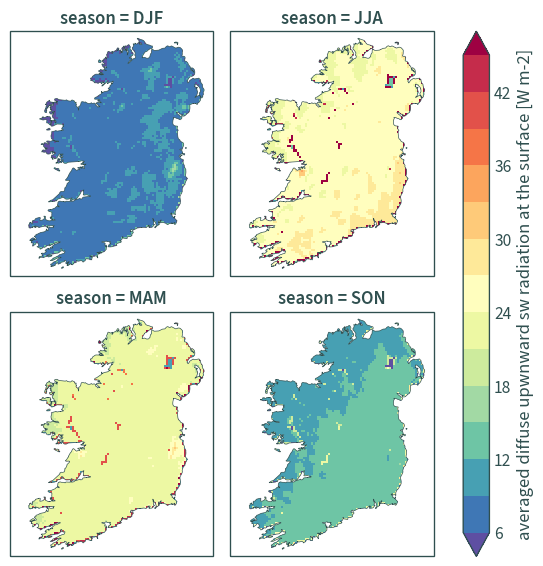

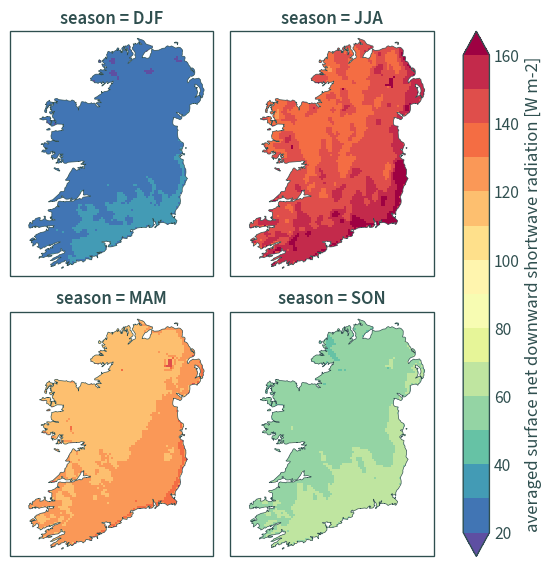

In [37]:
for var in ["ASWDIR_S", "ASWDIFD_S", "ASWDIFU_S", "ASOB_S"]:
    cplt.plot_averages(
        data=data.sel(time=slice("1976", "2005")),
        var=var,
        averages="season",
        boundary_data=ie_ne,
        cbar_levels=15,
    )

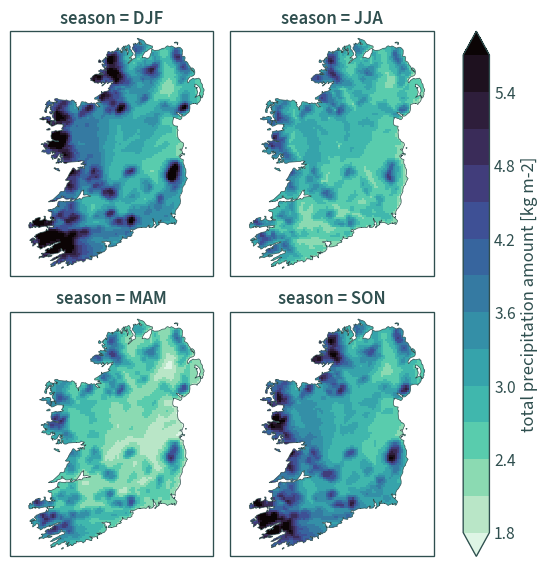

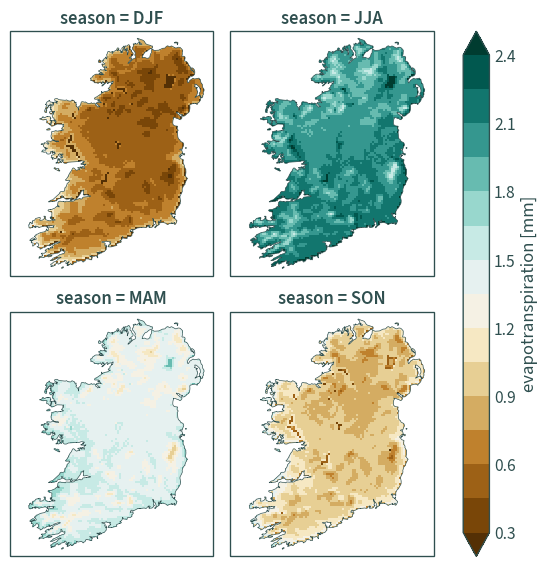

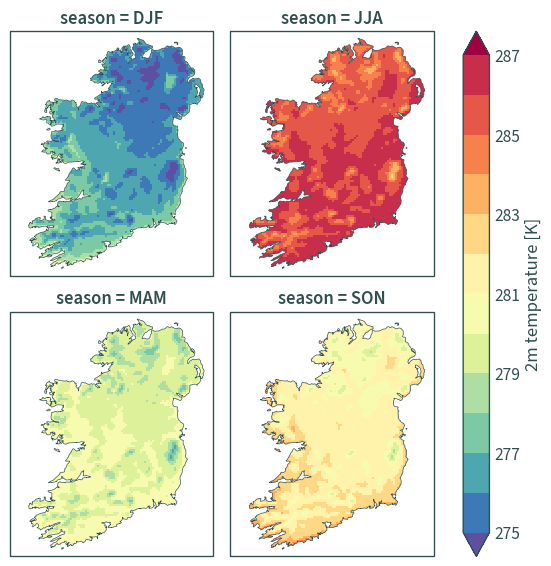

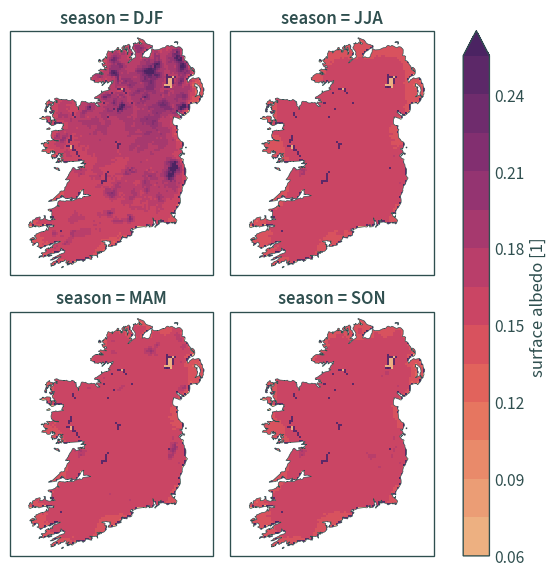

In [38]:
for var in ["TOT_PREC", "PET", "T_2M", "ALB_RAD"]:
    cplt.plot_averages(
        data=data.sel(time=slice("1976", "2005")),
        var=var,
        averages="season",
        boundary_data=ie_ne,
        cbar_levels=15,
    )

### Time series

In [39]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

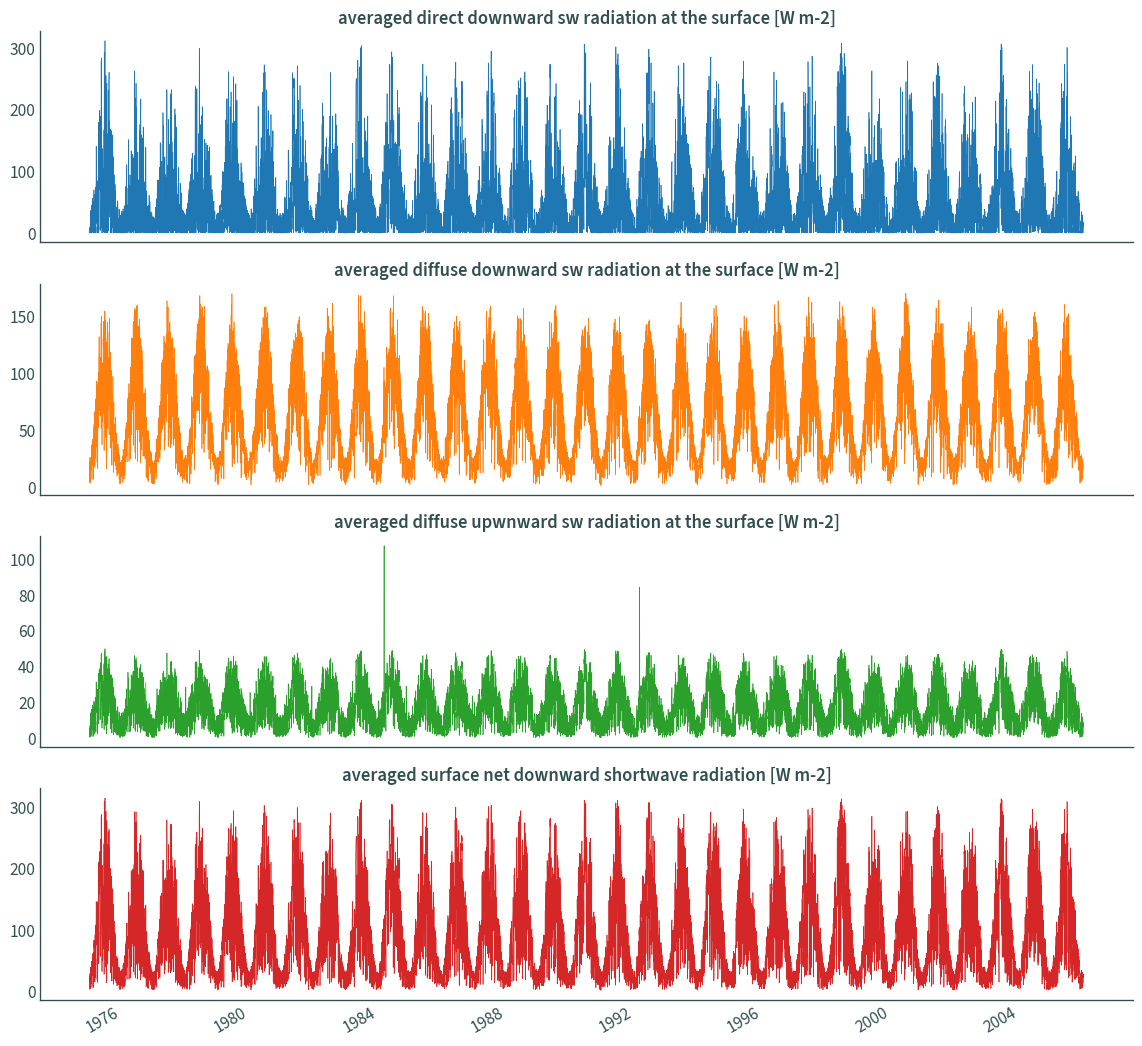

In [40]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in ["ASWDIR_S", "ASWDIFD_S", "ASWDIFU_S", "ASOB_S"]:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(4, 1),
    figsize=(12, 11),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=0.5,
)
sns.despine()
plt.tight_layout()
plt.show()

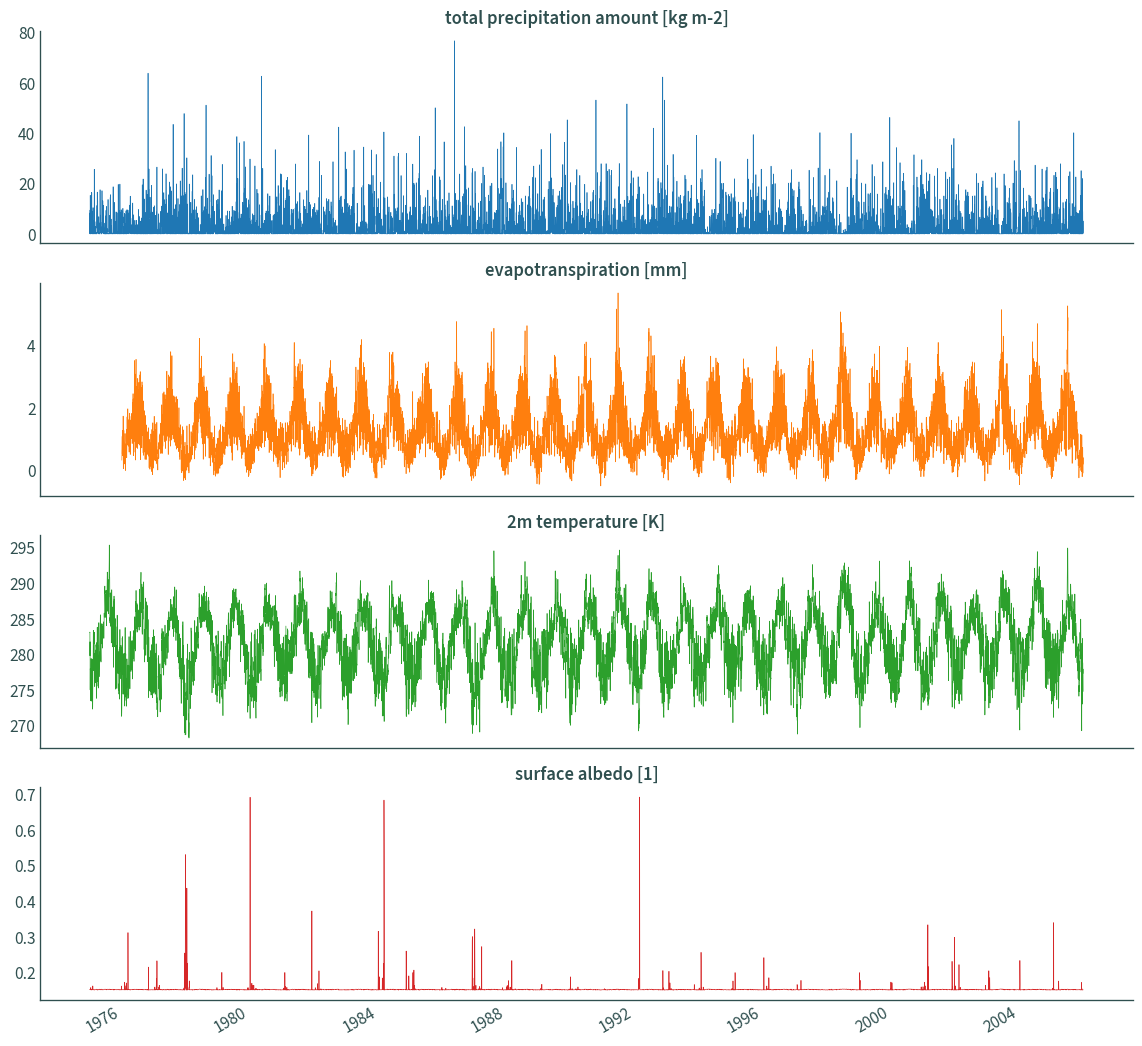

In [41]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in ["TOT_PREC", "PET", "T_2M", "ALB_RAD"]:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(4, 1),
    figsize=(12, 11),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=0.5,
)
sns.despine()
plt.tight_layout()
plt.show()

### Box plots

In [42]:
data_ie = data_ie.sel(time=slice("1976", "2005"))

In [43]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
data_ie_df.set_index("time", inplace=True)

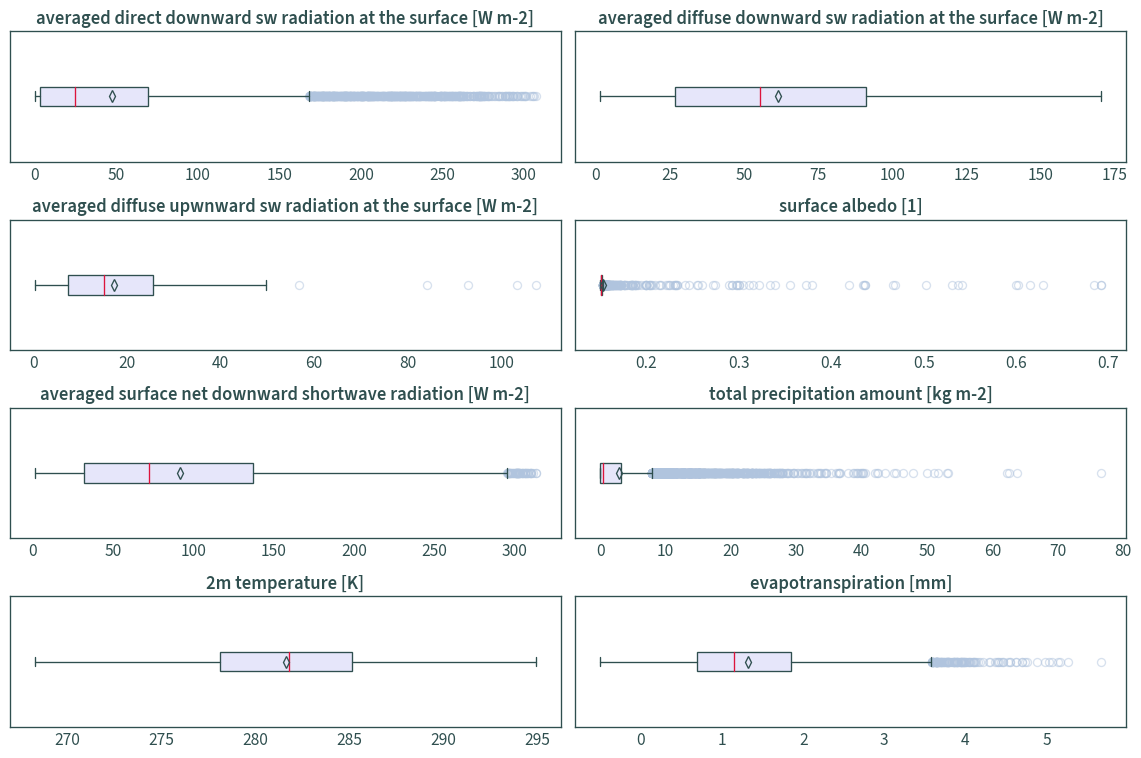

In [44]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))
for ax, var in zip(axs.flat, data_ie.data_vars):
    data_ie_df.plot.box(
        column=var,
        vert=False,
        showmeans=True,
        ax=ax,
        patch_artist=True,
        color={
            "medians": "Crimson",
            "whiskers": "DarkSlateGrey",
            "caps": "DarkSlateGrey",
        },
        boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
        meanprops={
            "markeredgecolor": "DarkSlateGrey",
            "marker": "d",
            "markerfacecolor": (1, 1, 0, 0),  # transparent
        },
        flierprops={
            "alpha": 0.5,
            "markeredgecolor": "LightSteelBlue",
            "zorder": 1,
        },
    )
    ax.set_title(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )
    ax.set(yticklabels=[])
plt.tight_layout()
plt.show()

## Calculate surface downwelling shortwave radiation

### Using direct and diffuse downward components

In [45]:
data = data.assign(rsds=data["ASWDIR_S"] + data["ASWDIFD_S"])
data["rsds"].attrs["units"] = "W m-2"
data["rsds"].attrs["long_name"] = "Surface Downwelling Shortwave Radiation"

## Calculate photosynthetically active radiation

In [46]:
# Papaioannou et al. (1993) - irradiance ratio
data = data.assign(PAR=data["rsds"] * 0.473)

In [47]:
# compare radiation vals
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1997", "1999")
)

In [48]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in ["rsds", "ASOB_S", "ASWDIFD_S", "ASWDIR_S", "PAR"]:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)

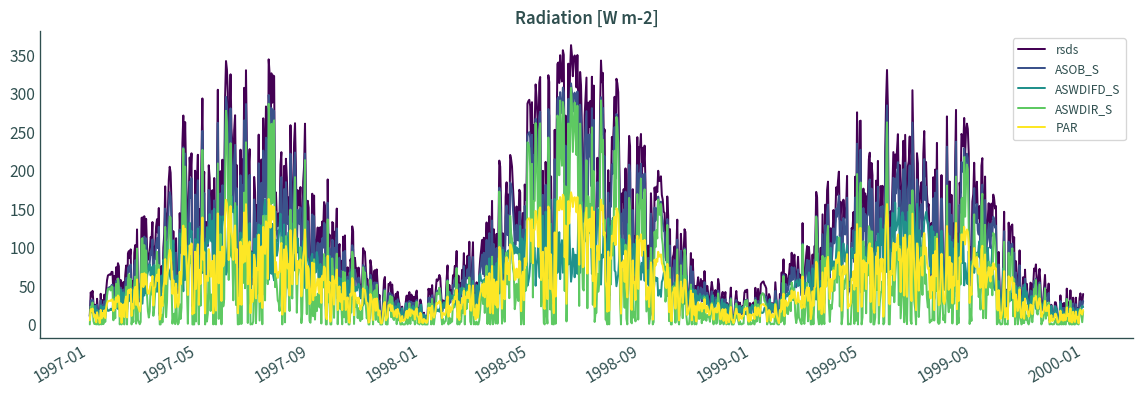

In [49]:
data_ie_df.plot(figsize=(12, 4), colormap="viridis", xlabel="")
plt.tight_layout()
plt.title("Radiation [W m-2]")
sns.despine()
plt.show()

In [50]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1976", "2005")
)

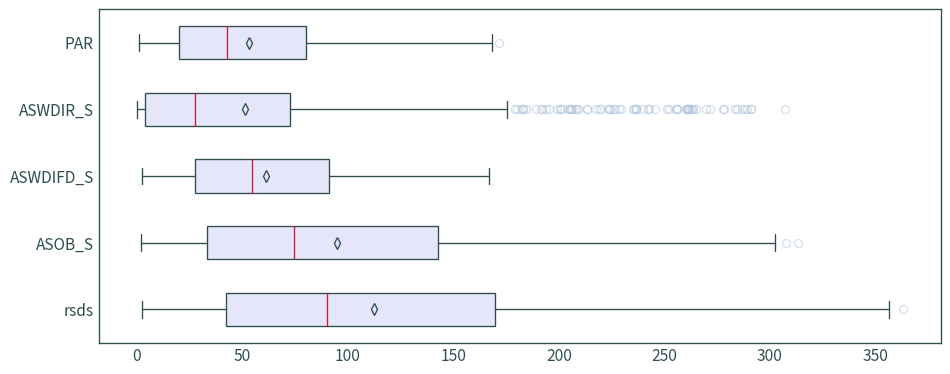

In [51]:
fig = data_ie_df.plot.box(
    vert=False,
    showmeans=True,
    figsize=(10, 4),
    patch_artist=True,
    color={
        "medians": "Crimson",
        "whiskers": "DarkSlateGrey",
        "caps": "DarkSlateGrey",
    },
    boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
    meanprops={
        "markeredgecolor": "DarkSlateGrey",
        "marker": "d",
        "markerfacecolor": (1, 1, 0, 0),  # transparent
    },
    flierprops={
        "alpha": 0.5,
        "markeredgecolor": "LightSteelBlue",
        "zorder": 1,
    },
)
plt.tight_layout()
plt.show()

## Convert units and rename variables

In [52]:
for v in data.data_vars:
    var_attrs = data[v].attrs  # extract attributes
    if v == "T_2M":
        var_attrs["units"] = "°C"
        data[v] = data[v] - 273.15
        var_attrs["note"] = "Converted from K to °C by subtracting 273.15"
        var_attrs["long_name"] = "Near-Surface Air Temperature"
    elif v == "PAR":
        var_attrs["units"] = "MJ m⁻² day⁻¹"
        data[v] = data[v] * (60 * 60 * 24 / 1e6)
        var_attrs["long_name"] = "Surface Photosynthetically Active Radiation"
        var_attrs["note"] = (
            "Calculated by multiplying the surface downwelling shortwave "
            "radiation (calculated by summing the direct and diffuse "
            "downward shortwave radiation components) with an irradiance "
            "ratio of 0.473 based on Papaioannou et al. (1993); converted "
            "from W m⁻² to MJ m⁻² day⁻¹ by multiplying 0.0864 as "
            "documented in the FAO Irrigation and Drainage Paper No. "
            "56 (Allen et al., 1998, p. 45)"
        )
    elif v in ("TOT_PREC", "PET", "w"):
        var_attrs["units"] = "mm day⁻¹"
        if v in ("w", "PET"):
            var_attrs["long_name"] = "Potential Evapotranspiration"
        else:
            var_attrs["long_name"] = "Precipitation"
            var_attrs["note"] = (
                "kg m⁻² is equivalent to mm day⁻¹, assuming a water density "
                "of 1,000 kg m⁻³"
            )
    data[v].attrs = var_attrs  # reassign attributes

In [53]:
# rename
data = data.rename({"T_2M": "T", "TOT_PREC": "PP"})

In [54]:
# remove dataset history
del data.attrs["history"]

In [55]:
# assign dataset name
data.attrs["dataset"] = f"IE_HiResIreland_{data.attrs['title'][:-4]}"

In [56]:
# keep only required variables
data = data.drop_vars(
    ["ASWDIR_S", "ASWDIFD_S", "ASWDIFU_S", "ALB_RAD", "ASOB_S", "rsds"]
)

In [57]:
# assign attributes to the data
data.attrs["comment"] = (
    "This dataset has been clipped with the Island of Ireland's boundary and "
    "units have been converted. Last updated: "
    + str(datetime.now(tz=timezone.utc))
    + " by nstreethran@ucc.ie."
)

In [58]:
# reassign time_bnds
data.coords["time_bnds"] = data_time_bnds

In [59]:
# reassign CRS
data.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:       (time: 11323, rlon: 90, rlat: 116, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 2005-12-31T10...
  * rlon          (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat          (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
    lon           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    height_2m     float32 2.0
    spatial_ref   int64 0
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    rotated_pole  int64 0
Dimensions without coordinates: bnds
Data variables:
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(365, 71, 53), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(365, 71, 53), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(6679, 71, 53), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(4875, 46, 32), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

## Visualise

### Seasonal averages

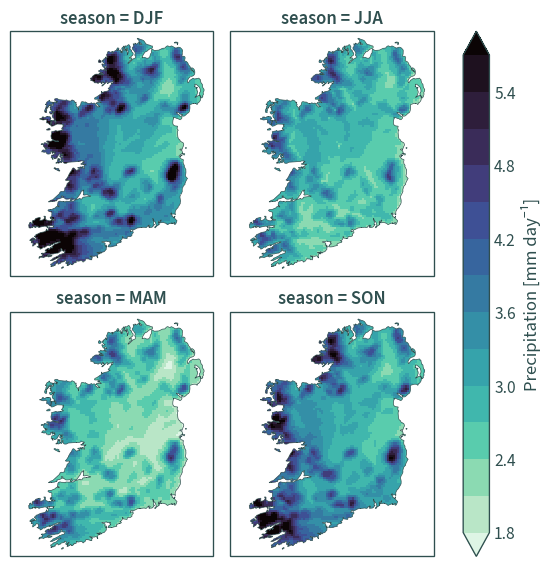

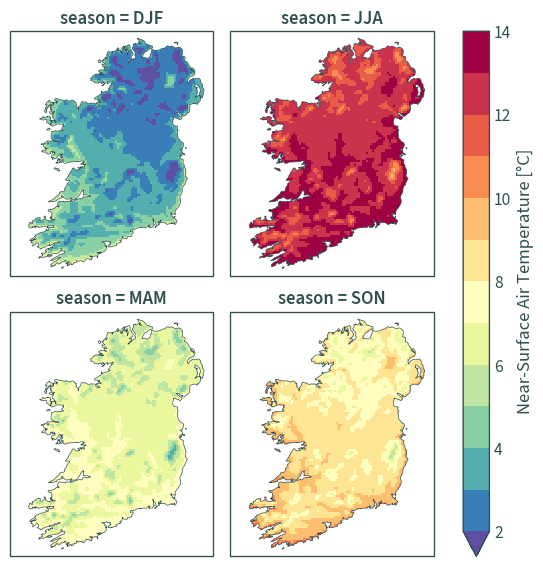

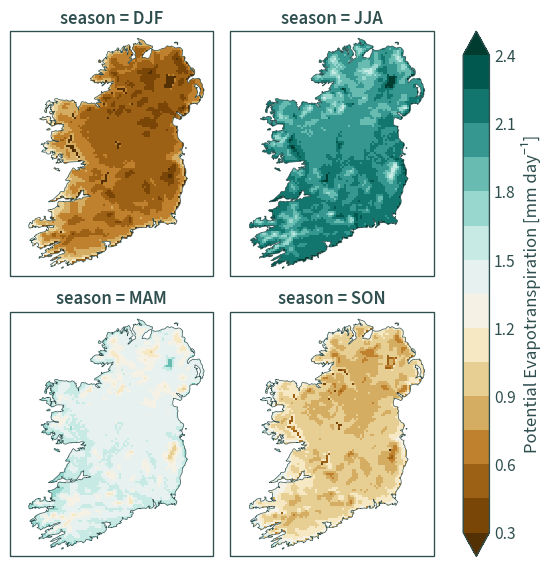

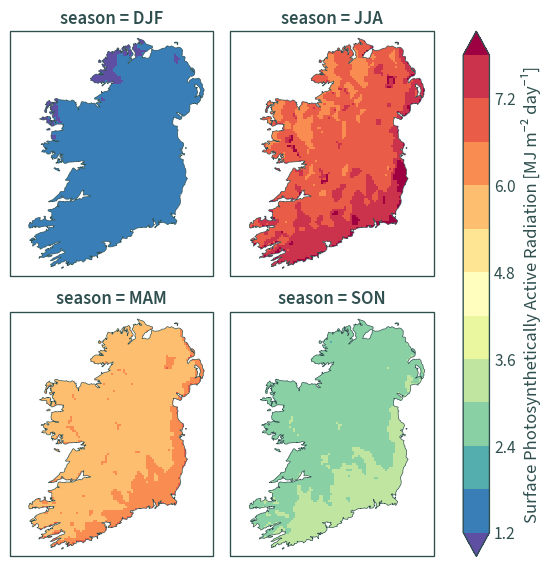

In [60]:
for var in data.data_vars:
    cplt.plot_averages(
        data=data.sel(time=slice("1976", "2005")),
        var=var,
        averages="season",
        boundary_data=ie_ne,
        cbar_levels=14,
    )

### Time series

In [61]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

In [62]:
data_ie

<xarray.Dataset>
Dimensions:       (time: 11323, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 2005-12-31T10...
    rlon          float64 -0.21
    rlat          float64 -1.245
    lon           float32 dask.array<chunksize=(), meta=np.ndarray>
    lat           float32 dask.array<chunksize=(), meta=np.ndarray>
    height_2m     float32 2.0
    spatial_ref   int64 0
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    rotated_pole  int64 0
Dimensions without coordinates: bnds
Data variables:
    PP            (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    T             (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    PET           (time) float32 dask.array<chunksize=(6679,), meta=np.ndarray>
    PAR           (time) float32 dask.array<chunksize=(4875,), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

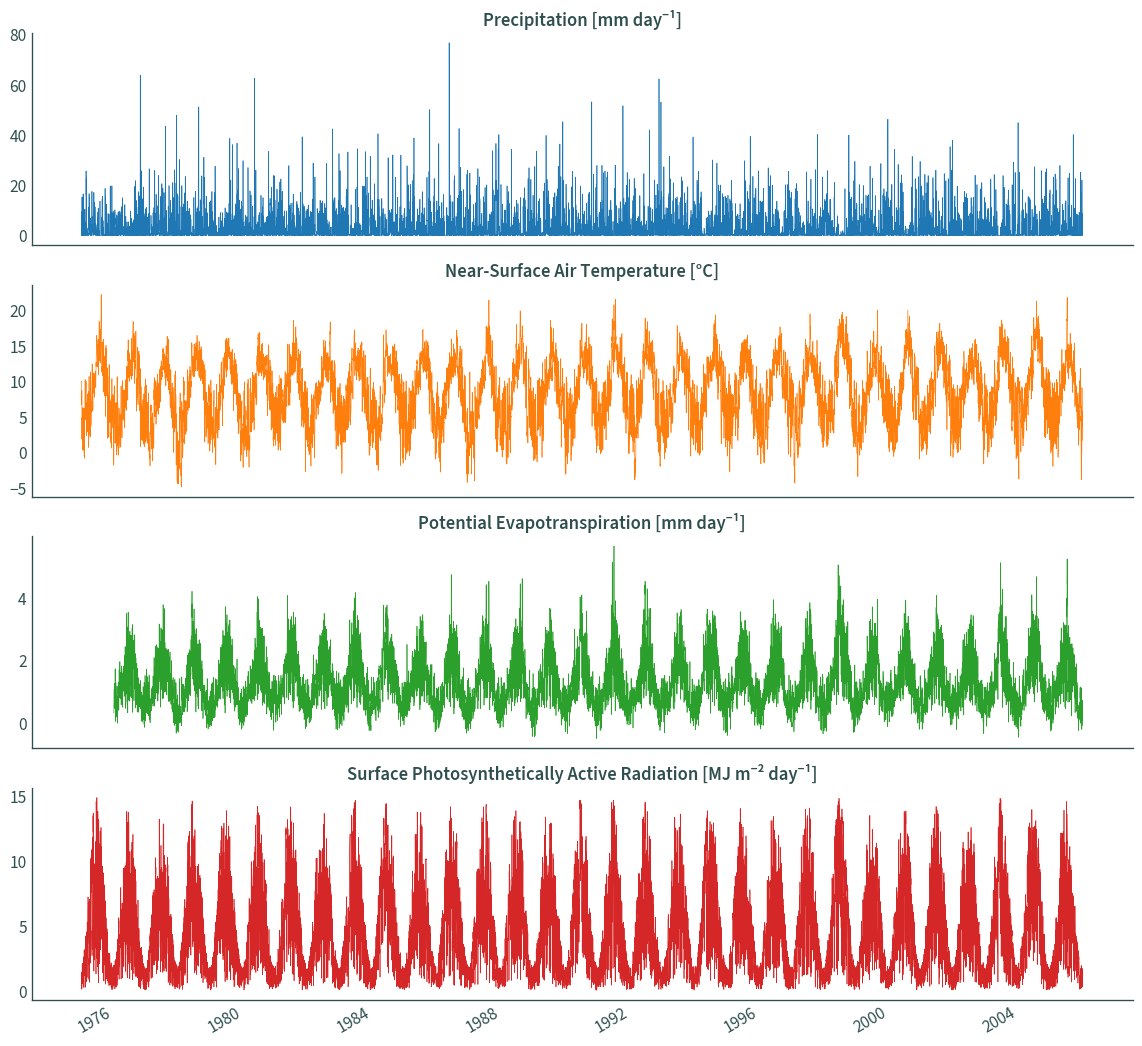

In [63]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(4, 1),
    figsize=(12, 11),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=0.5,
)
sns.despine()
plt.tight_layout()
plt.show()

### Box plots

In [64]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1976", "2005")
)

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
data_ie_df.set_index("time", inplace=True)

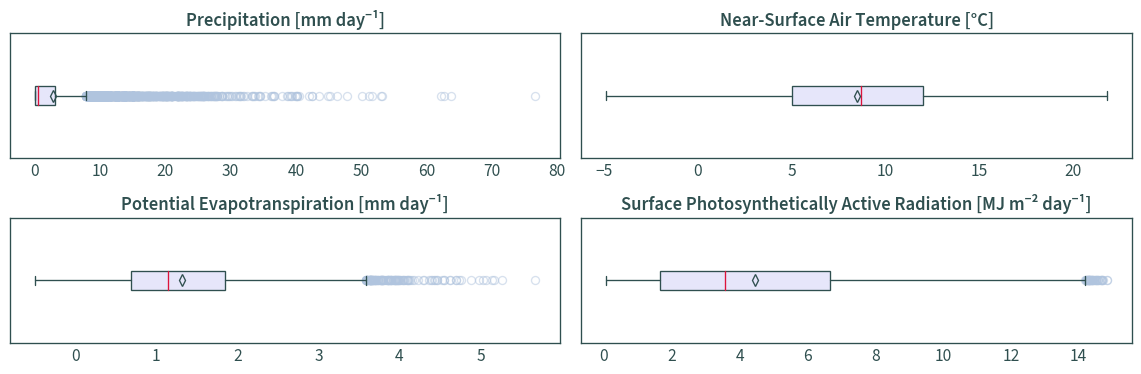

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
for ax, var in zip(axs.flat, data_ie.data_vars):
    data_ie_df.plot.box(
        column=var,
        vert=False,
        showmeans=True,
        ax=ax,
        patch_artist=True,
        color={
            "medians": "Crimson",
            "whiskers": "DarkSlateGrey",
            "caps": "DarkSlateGrey",
        },
        boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
        meanprops={
            "markeredgecolor": "DarkSlateGrey",
            "marker": "d",
            "markerfacecolor": (1, 1, 0, 0),  # transparent
        },
        flierprops={
            "alpha": 0.5,
            "markeredgecolor": "LightSteelBlue",
            "zorder": 1,
        },
    )
    ax.set_title(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )
    ax.set(yticklabels=[])
plt.tight_layout()
plt.show()

## Extend data to a spin-up year

In [66]:
data = data.sel(time=slice("1976", "2005"))

In [67]:
data_interp = data.interp(
    time=pd.date_range(
        f"{int(data['time'][0].dt.year) - 1}-01-01T10:30:00",
        f"{int(data['time'][0].dt.year) - 1}-12-31T10:30:00",
        freq="D",
    ),
    kwargs={"fill_value": None},
)

In [68]:
data_interp.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:       (rlon: 90, rlat: 116, time: 365)
Coordinates:
  * rlon          (rlon) float64 -1.68 -1.645 -1.61 -1.575 ... 1.365 1.4 1.435
  * rlat          (rlat) float64 -1.98 -1.945 -1.91 -1.875 ... 1.975 2.01 2.045
    lon           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(116, 90), meta=np.ndarray>
    height_2m     float32 2.0
    spatial_ref   int64 0
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 1975-12-31T10...
    rotated_pole  int64 0
Data variables:
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(365, 71, 53), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(365, 71, 53), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(365, 71, 53), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(365, 46, 32), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

In [ ]:
# merge spin-up year with first two years of the main data
data_interp = xr.combine_by_coords(
    [
        data_interp,
        data.sel(
            time=slice(
                str(int(data["time"][0].dt.year)),
                str(int(data["time"][0].dt.year) + 1),
            )
        ),
    ]
)

In [ ]:
data_interp

<xarray.Dataset>
Dimensions:       (rlon: 85, rlat: 113, time: 1096)
Coordinates:
  * rlon          (rlon) float64 -1.54 -1.505 -1.47 -1.435 ... 1.33 1.365 1.4
  * rlat          (rlat) float64 -1.945 -1.91 -1.875 -1.84 ... 1.905 1.94 1.975
    lon           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    height_2m     float32 2.0
    rotated_pole  int64 0
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 1977-12-31T10...
    spatial_ref   int64 0
Data variables:
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(365, 45, 28), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

In [ ]:
data_ie = data_interp.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

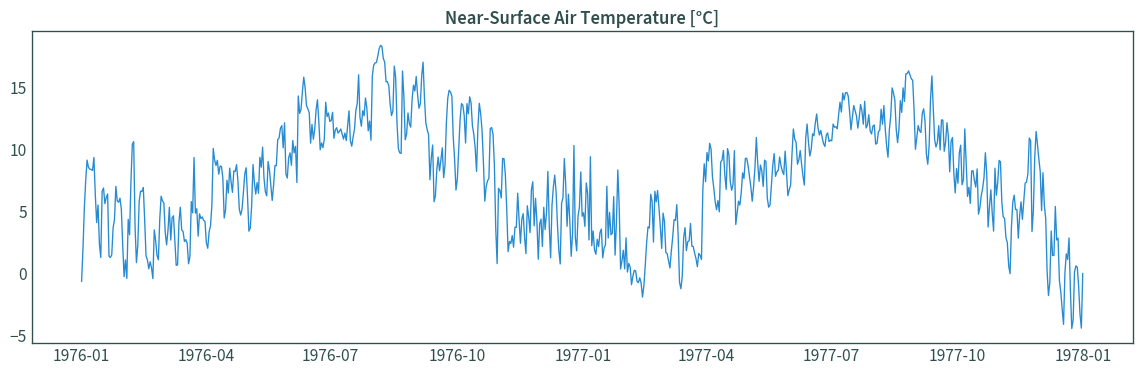

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(data_ie["time"], data_ie["T"], linewidth=1)
plt.title(f"{data_ie['T'].attrs['long_name']} [{data_ie['T'].attrs['units']}]")
sns.despine()
plt.tight_layout()
plt.show()

In [65]:
# check value for the first day of the first year
data_ie["T"][
    data_interp.sel(time=str(int(data_interp["time"][0].dt.year))).dims["time"]
].values

array(-0.6647644, dtype=float32)

In [66]:
# check first value of spin-up year - should be nan
data_ie["T"][0].values

array(nan)

In [67]:
# shift first year of the main data to the spin-up year
data_interp = data_interp.shift(
    time=-data_interp.sel(time=str(int(data_interp["time"][0].dt.year))).dims[
        "time"
    ]
)

In [68]:
data_ie = data_interp.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

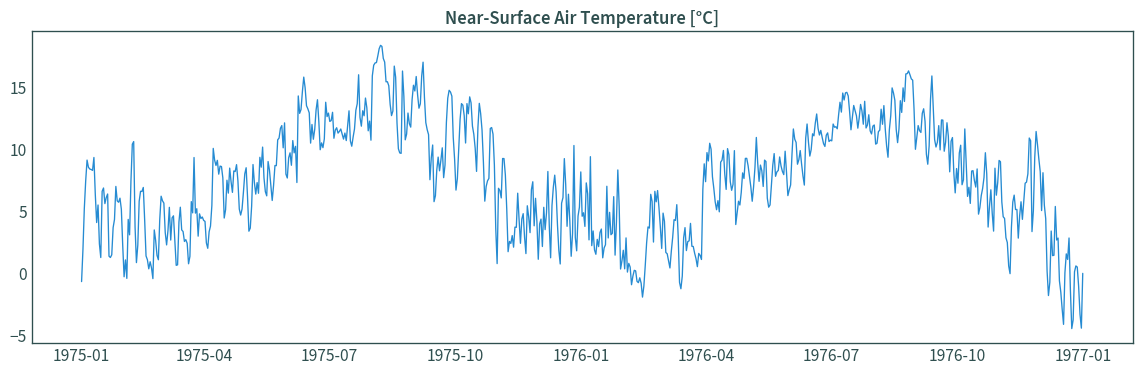

In [70]:
# should be the same as before, but shifted forwards to the spin-up year
plt.figure(figsize=(12, 4))
plt.plot(data_ie["time"], data_ie["T"], linewidth=1)
plt.title(f"{data_ie['T'].attrs['long_name']} [{data_ie['T'].attrs['units']}]")
plt.tight_layout()
plt.show()

In [71]:
# check first value
data_ie["T"][0].values

array(-0.6647644, dtype=float32)

In [72]:
# keep only spin-up year
data_interp = data_interp.sel(time=str(int(data_interp["time"][0].dt.year)))

In [73]:
data_interp

<xarray.Dataset>
Dimensions:       (rlon: 85, rlat: 113, time: 365)
Coordinates:
  * rlon          (rlon) float64 -1.54 -1.505 -1.47 -1.435 ... 1.33 1.365 1.4
  * rlat          (rlat) float64 -1.945 -1.91 -1.875 -1.84 ... 1.905 1.94 1.975
    lon           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    height_2m     float32 2.0
    rotated_pole  int64 0
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 1975-12-31T10...
    spatial_ref   int64 0
Data variables:
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(365, 45, 28), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

In [74]:
# merge with main dataset
data = xr.combine_by_coords([data, data_interp])

In [75]:
data

<xarray.Dataset>
Dimensions:       (rlon: 85, rlat: 113, time: 11323)
Coordinates:
  * rlon          (rlon) float64 -1.54 -1.505 -1.47 -1.435 ... 1.33 1.365 1.4
  * rlat          (rlat) float64 -1.945 -1.91 -1.875 -1.84 ... 1.905 1.94 1.975
    lon           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    lat           (rlat, rlon) float32 dask.array<chunksize=(113, 85), meta=np.ndarray>
    height_2m     float32 2.0
    rotated_pole  int64 0
  * time          (time) datetime64[ns] 1975-01-01T10:30:00 ... 2005-12-31T10...
    spatial_ref   int64 0
Data variables:
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(365, 70, 49), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(365, 45, 28), meta=np.ndarray>
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           COSMO5_EC-EARTH_historical_4km
    experiment_id:   COSMO5_EC-EARTH_historical_4km
    realization:     1
    conventionsURL:  http://www.cfconventions.org/
    ...              ...
    references:      http://www.ichec.ie
    creation_date:   2017-08-19 08:17:04
    frequency:       day
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...
    dataset:         IE_HiResIreland_COSMO5_EC-EARTH_historical
    comment:         This dataset has been clipped with the Island of Ireland...

In [76]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1975", "1977")
)

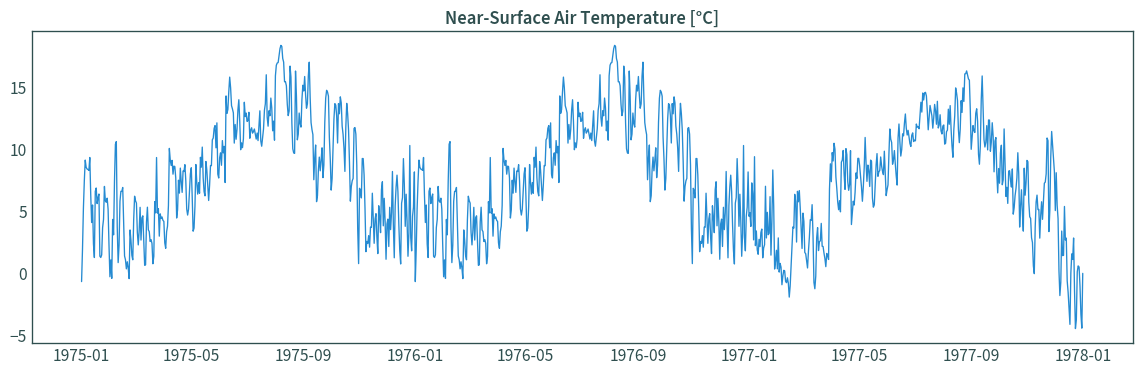

In [77]:
# spin-up year and first year should be identical
plt.figure(figsize=(12, 4))
plt.plot(data_ie["time"], data_ie["T"], linewidth=1)
plt.title(f"{data_ie['T'].attrs['long_name']} [{data_ie['T'].attrs['units']}]")
plt.tight_layout()
plt.show()